In [1]:
device = 'cuda:3'

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm import tqdm
from include import *
import torch.optim as optim

In [3]:
def crop_center(img):    
    new_width=256
    new_height=256

    width, height = img.size   # Get dimensions

    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2

    # Crop the center of the image
    img = img.crop((left, top, right, bottom))
    
    return np.array(img)

def add_noise(img, sigma):
    noise = np.float32(np.random.normal(0, sigma/255, (3,256,256)))
    noisy_img=np.clip(img+noise,0,1)
    
    return noisy_img

In [4]:
img = Image.open('./car.png')
img = crop_center(img)
img = img.reshape(3,256,256)  
clean_img = np.float32(img/np.max(img)) 
noisy_img = add_noise(clean_img, 255)

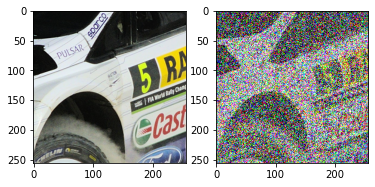

In [5]:
f, plots = plt.subplots(1,2)
plots[0].imshow(clean_img.reshape(256,256,3))
plots[1].imshow(noisy_img.reshape(256,256,3))

In [6]:
noisy_img = torch.FloatTensor(noisy_img).to(device)
clean_img = torch.FloatTensor(clean_img).to(device)

noise = noisy_img - clean_img
#Input = torch.rand((1,3,256,256)).to(device)
net_input = torch.zeros((1,3,256,256))
net_input.data.uniform_()
net_input.data *= 1./10
Input = net_input.to(device)

In [7]:
model_a = Unet().to(device)
model_b = Unet().to(device)
model_c = Unet().to(device)

In [8]:
##Functions

##Loss
def mse(gt: torch.Tensor, pred:torch.Tensor)-> torch.Tensor:
    loss = torch.nn.MSELoss()
    return loss(gt,pred)

#train
def train(model, optimizer, Input, clean_img, noisy_img):
    model.train()
    
    # reset optimizer's gradient
    optimizer.zero_grad()
    
    # get the prediction
    pred = model(Input)

    mse_noisy = mse(pred, noisy_img.unsqueeze(0))
    mse_clean = mse(pred, clean_img.unsqueeze(0))
    
    #one step of training
    mse_noisy.backward()
    optimizer.step()

    return mse_noisy.item(), mse_clean.item()


def fit(model, optimizer, Input, img):
    model.train()
    
    # reset optimizer's gradient
    optimizer.zero_grad()
    
    # get the prediction
    pred = model(Input)

    mse_pred = mse(pred, img.unsqueeze(0))
    
    #one step of training
    mse_pred.backward()
    optimizer.step()

    return mse_pred.item()


In [9]:
#fitting noisy image

optimizer = optim.Adam(model_a.parameters(), lr=0.005, weight_decay=0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)

max_epoch = 2000
mse_noisy=[]
mse_clean=[]


for i in range(max_epoch):
    
    a,b = train(model_a, optimizer, Input, clean_img, noisy_img)
    
    mse_noisy.append(a)
    mse_clean.append(b)
    
    scheduler.step()
    
    if i%50 == 0:
        print(i, a,b, end='\r')
        


In [10]:
#fitting clean image

optimizer = optim.Adam(model_b.parameters(), lr=0.005, weight_decay=0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)

max_epoch = 2000
clean=[]

for i in range(max_epoch):
    
    err = fit(model_b, optimizer, Input, clean_img)
    clean.append(err)

    scheduler.step()
    
    if i%50 == 0:
        print(i, err, end='\r')

In [11]:
#fitting noise

optimizer = optim.Adam(model_c.parameters(), lr=0.005, weight_decay=0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)

max_epoch = 2000
noisy=[]

for i in range(max_epoch):
    
    err = fit(model_c, optimizer, Input, noise)
    noisy.append(err)

    scheduler.step()
    
    if i%50 == 0:
        print(i, err, end='\r')

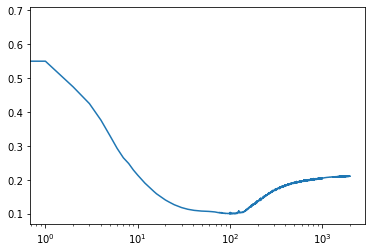

In [12]:
plt.plot(mse_clean)
plt.xscale("log")

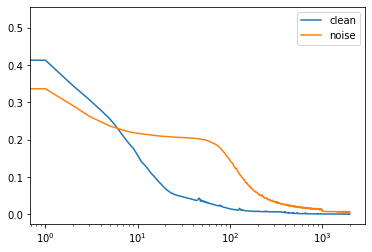

In [13]:
plt.plot(clean, label ='clean')
plt.plot(noisy, label = 'noise')
plt.legend()
plt.xscale("log")